In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [2]:
model  = models.vgg19(pretrained=True).features

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 78.7MB/s]


In [3]:
model #0, 5, 10, 19, 28 layers are needed

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
model[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [5]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.chosen_features = ['0', '5', '10', '19', '28']
        self.model = models.vgg19(pretrained=True).features[:29]

    def forward(self, x):
        features = []
        for layer_num, layer  in enumerate(self.model):
            x = layer(x)

            if str(layer_num) in self.chosen_features:
                features.append(x)

        return features

##Загрузка картинок

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_size = 356

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

def load_image(path: str):
    image = Image.open(path)
    image = transform(image).unsqueeze(0)
    return image.to(device)

def show_tensor(img):
    img_prep = img.squeeze()
    img_prep = torch.permute(img_prep, (1,2,0)).detach().cpu().numpy()
    return img_prep

In [7]:
device

device(type='cuda')

In [8]:
orig = load_image("/content/drive/MyDrive/imgs/mrgabagool.jpg")
style = load_image('/content/drive/MyDrive/imgs/picasso.jpg')

In [9]:
generated = orig.clone()
generated.requires_grad = True

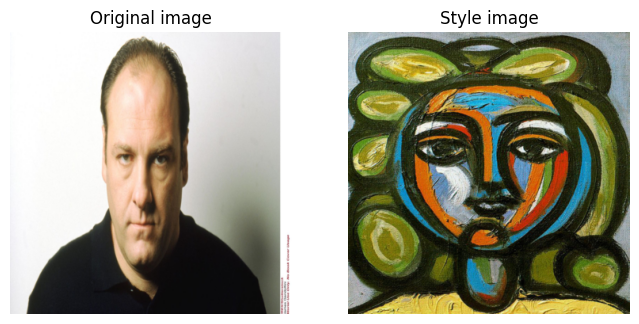

In [53]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow(show_tensor(orig))
ax[0].set_title('Original image')
ax[0].axis(False)

ax[1].imshow(show_tensor(style))
ax[1].set_title('Style image')
ax[1].axis(False)

plt.show()

##Тренировочной цикл

In [11]:
epochs = 6000
lr = 0.001
alpha = 1
beta = 0.01
optimizer = optim.Adam([generated], lr=lr)

model = VGG().to(device).eval()

In [12]:

for epoch in range(epochs):
    progress = []

    #получение признаков всех картинок со всерток VGG
    gen_features = model(generated)
    orig_features = model(orig)
    style_features = model(style)

    #ошибка контента и стиля
    original_loss=0
    style_loss = 0

    for gen_feature, orig_feature, style_feature in zip(
        gen_features, orig_features, style_features
    ):
        batch_size, channel, height, width = gen_feature.shape

        original_loss += torch.mean((gen_feature - orig_feature)**2)

        G = gen_feature.view(channel, height*width).mm(
            gen_feature.view(channel, height*width).t()
        )

        A = style_feature.view(channel, height*width).mm(
            style_feature.view(channel, height*width).t()
        )

        style_loss += torch.mean((G - A)**2)

    total_loss = alpha*original_loss + beta*style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f'epoch: {epoch}|loss:{total_loss}')
        progress.append(generated)


epoch: 0|loss:1059573.5
epoch: 200|loss:68068.6171875
epoch: 400|loss:36965.40234375
epoch: 600|loss:27665.9765625
epoch: 800|loss:22374.728515625
epoch: 1000|loss:18688.212890625
epoch: 1200|loss:15891.2353515625
epoch: 1400|loss:13640.6279296875
epoch: 1600|loss:11796.8681640625
epoch: 1800|loss:10276.28515625
epoch: 2000|loss:9013.87890625
epoch: 2200|loss:7954.5771484375
epoch: 2400|loss:7061.9248046875
epoch: 2600|loss:6301.4384765625
epoch: 2800|loss:5653.7431640625
epoch: 3000|loss:5097.07568359375
epoch: 3200|loss:4616.87353515625
epoch: 3400|loss:4202.7099609375
epoch: 3600|loss:3844.05224609375
epoch: 3800|loss:3532.669921875
epoch: 4000|loss:3259.007080078125
epoch: 4200|loss:3020.685302734375
epoch: 4400|loss:2816.45361328125
epoch: 4600|loss:2631.20166015625
epoch: 4800|loss:2474.551513671875
epoch: 5000|loss:2337.87646484375
epoch: 5200|loss:2212.822265625
epoch: 5400|loss:2104.915771484375
epoch: 5600|loss:2004.470458984375
epoch: 5800|loss:1923.29248046875


##Итог

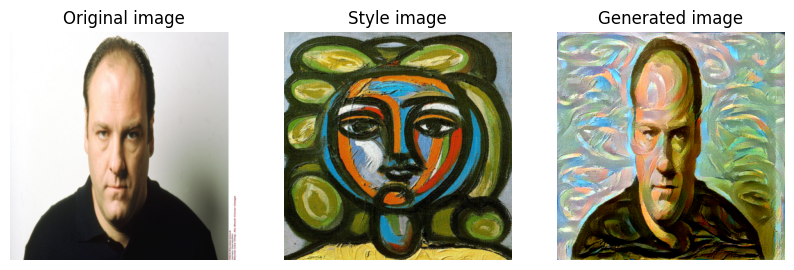

In [54]:
fig, ax = plt.subplots(1,3, figsize=(10,6))
ax[0].imshow(show_tensor(orig))
ax[0].set_title('Original image')
ax[0].axis(False)

ax[1].imshow(show_tensor(style))
ax[1].set_title('Style image')
ax[1].axis(False)

ax[2].imshow(show_tensor(generated))
ax[2].set_title('Generated image')
ax[2].axis(False)

plt.show()